# Exercise

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/simaki/fracdiff/blob/master/sample/exercise/exercise.ipynb)

In [1]:
# !pip install cointanalysis matplotlib numpy pandas pandas_datareader scipy seaborn sklearn statsmodels
# !pip install fracdiff

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader
import seaborn
from statsmodels.tsa.stattools import adfuller

from fracdiff import Fracdiff, FracdiffStat, fdiff

seaborn.set_style("white")

In [3]:
def adf_test(array):
    """
    Carry out ADF unit-root test and print the result.
    """
    adf, pvalue, _, _, _, _ = adfuller(array)
    print("* ADF statistics: {:.3f}".format(adf))
    print("* ADF p-value: {:.3f}".format(pvalue))

## 5.1

- Prepare Gaussian, its cumsum and its differentiation.

In [4]:
np.random.seed(42)
gauss = np.random.randn(1000)
brown = gauss.cumsum()
overd = np.diff(gauss)

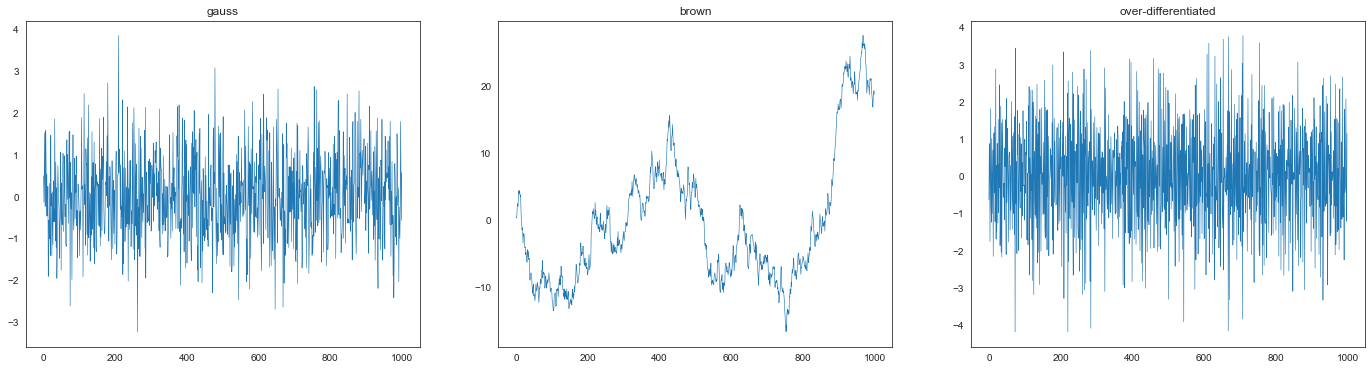

In [5]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(gauss, lw=0.6)
plt.title("gauss")

plt.subplot(1, 3, 2)
plt.plot(brown, lw=0.6)
plt.title("brown")

plt.subplot(1, 3, 3)
plt.plot(overd, lw=0.6)
plt.title("over-differentiated")

plt.show()

### 5.1 (a)

In [6]:
adf_test(gauss)

* ADF statistics: -31.811
* ADF p-value: 0.000


### 5.1 (b)

- Order of integration of cumsum is 1.

In [7]:
adf_test(brown)

* ADF statistics: -0.966
* ADF p-value: 0.765


### 5.1 (c)

- ADF statistics and p-value of over-differentiated process are:

In [8]:
adf_test(overd)

* ADF statistics: -11.486
* ADF p-value: 0.000


## 5.2

- Prepare `sin` function and the process given by `(sin + shift).cumsum()` (which we call `hop`):

In [9]:
sin = np.sin(np.linspace(0, 10 * np.pi, 1000))
hop = (sin + 0.1).cumsum()

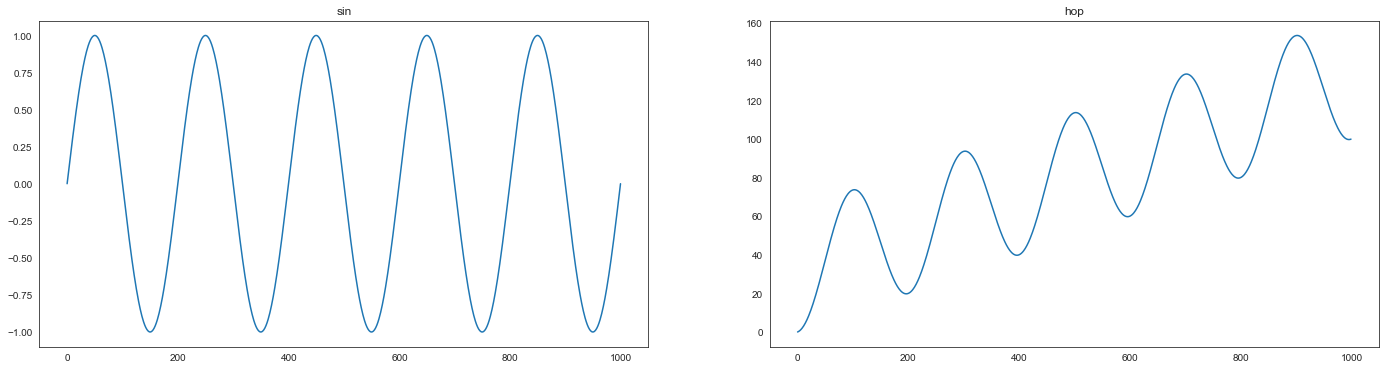

In [10]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.title("sin")
plt.plot(sin)

plt.subplot(1, 2, 2)
plt.title(f"hop")
plt.plot(hop)

plt.show()

### 5.2 (a)

In [11]:
adf_test(sin)

* ADF statistics: -13323341825676.293
* ADF p-value: 0.000


### 5.2 (b)

In [12]:
adf_test(hop)

* ADF statistics: -0.284
* ADF p-value: 0.928


- Let us see ADF p-values of fracdiff of `hop` with various orders:
- Notice: We will use the fixed-window method instead of expanding window method.

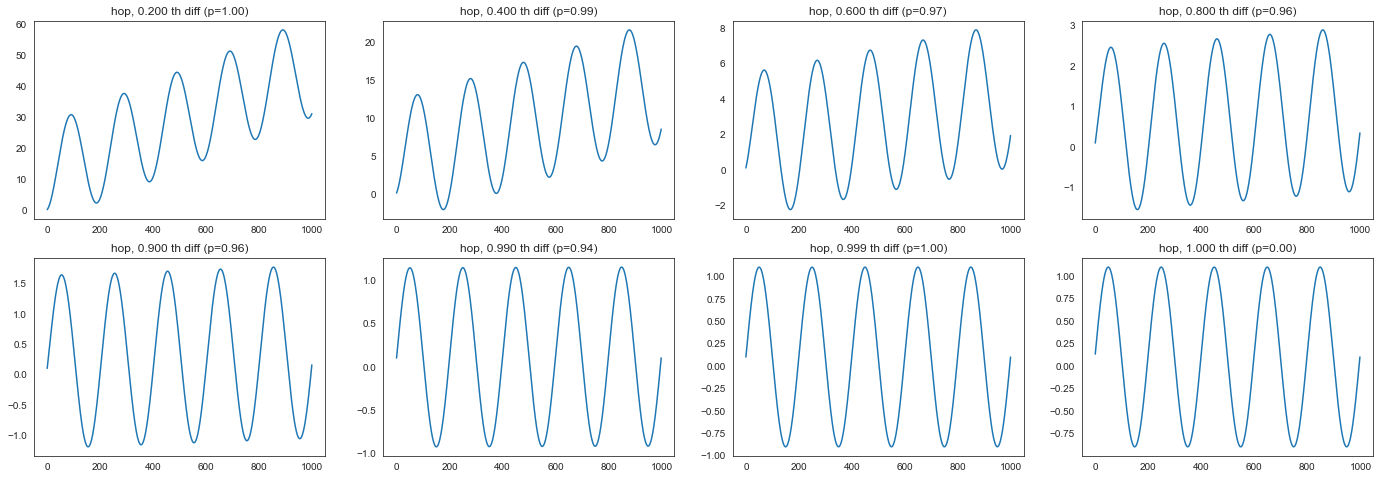

In [13]:
ds = (
    0.200,
    0.400,
    0.600,
    0.800,
    0.900,
    0.990,
    0.999,
    1.000,
)
window = 100

X = hop.reshape(-1, 1)

plt.figure(figsize=(24, 8))
for i, d in enumerate(ds):
    diff = fdiff(hop, d, window=window)
    _, pvalue, _, _, _, _ = adfuller(diff)

    plt.subplot(2, 4, i + 1)
    plt.title("hop, {:.3f} th diff (p={:.2f})".format(d, pvalue))
    plt.plot(diff)

- It seems that the minimum order is pretty close to `1.0`.
- Let us search the minimum using `FracdiffStat`.

In [14]:
precision = 10e-8

f = FracdiffStat(window=window, mode="valid", precision=precision, lower=0.9)

diff = f.fit_transform(X)

print(f"* Order: {f.d_[0]:.8f}")
adf_test(diff)

* Order: 0.99999971
* ADF statistics: -280803737.580
* ADF p-value: 0.000


In [16]:
# Check

diff = Fracdiff(f.d_[0] - precision, mode="valid").fit_transform(X)

print("* Order: {:.8f}".format(f.d_[0] - precision))
adf_test(diff)

* Order: 0.99999961
* ADF statistics: 0.001
* ADF p-value: 0.959


- Differentiated time-series looks like this:

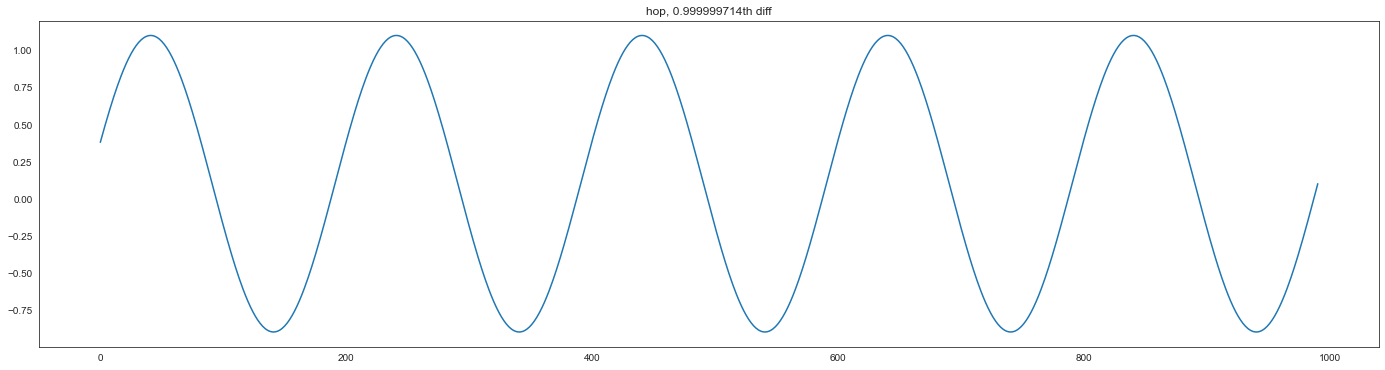

In [17]:
plt.figure(figsize=(24, 6))
plt.plot(diff)
plt.title(f"hop, {f.d_[0]:.9f}th diff")
plt.show()

## 5.3

### 5.3 (a)

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
linreg = LinearRegression()
linreg.fit(sin.reshape(-1, 1), hop)

print("* R-squared: {:.4f}".format(linreg.score(sin.reshape(-1, 1), hop)))

* R-squared: 0.0128


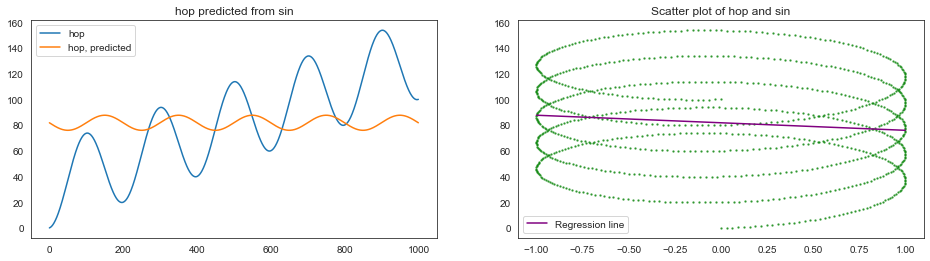

In [20]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.title("hop predicted from sin")
plt.plot(hop, label="hop")
plt.plot(linreg.predict(sin.reshape(-1, 1)), label="hop, predicted")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Scatter plot of hop and sin")
x = np.linspace(-1, 1, 2)
y = linreg.predict(x.reshape(-1, 1))
plt.scatter(sin, hop, s=2, alpha=0.6, color="green")
plt.plot(x, y, color="purple", label="Regression line")
plt.legend()

plt.show()

### 5.3 (b)

In [21]:
hopd = np.diff(hop)

linreg = LinearRegression()
linreg.fit(sin[1:].reshape(-1, 1), hopd)

print("* Coefficient: {}".format(linreg.coef_[0]))
print("* Intercept: {}".format(linreg.intercept_))
print("* R-squared: {:.4f}".format(linreg.score(sin[1:].reshape(-1, 1), hopd)))

* Coefficient: 0.9999999999999994
* Intercept: 0.1
* R-squared: 1.0000


### 5.3 (c)

- `d=1`. Because 1st order differentiation of `hop` is `sin` plus a constant.

## 5.4

- NOTE: We will use time-bar instead of dollar-bar.

In [22]:
def fetch_spx(begin="1998-01-01", end="2020-09-30"):
    return pandas_datareader.data.DataReader("^GSPC", "yahoo", begin, end)["Adj Close"]

In [23]:
spx = fetch_spx()

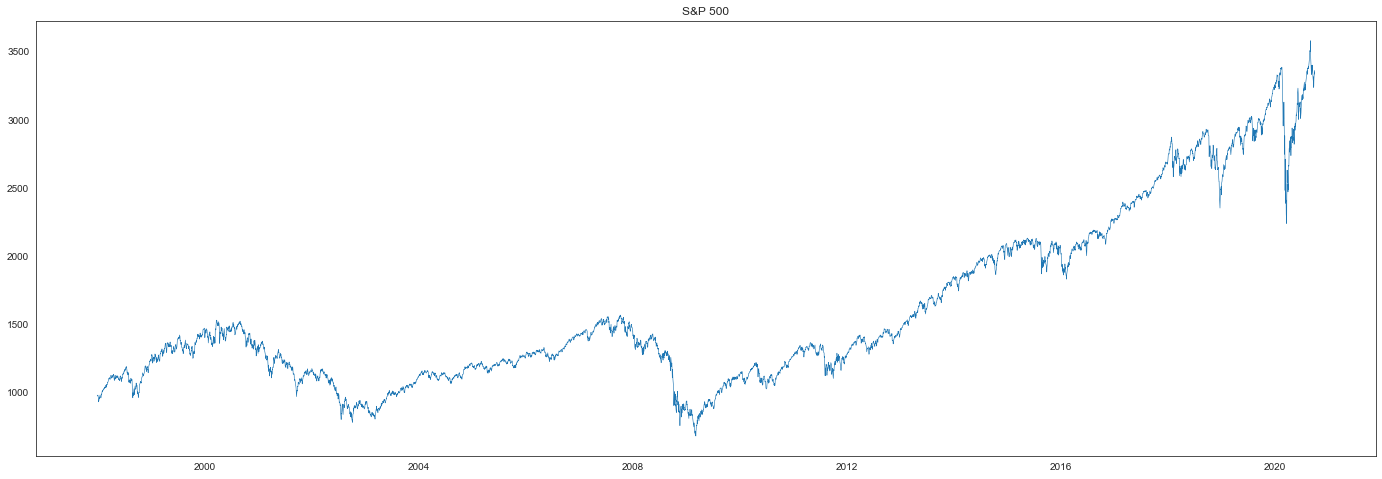

In [24]:
plt.figure(figsize=(24, 8))
plt.plot(spx, linewidth=0.6)
plt.title("S&P 500")
plt.show()

In [25]:
d = 0.2
window = 100

d0 = fdiff(spx.values, d, window=window, mode="full")
d1 = fdiff(d0, -d, window=window, mode="full")

spxd = pd.Series(d0, index=spx.index)
spxi = pd.Series(d1, index=spx.index)

- What we get is, in principle, the original time-series plus some constant.
- While there are small numerical errors due to the cut-off of a sequence of coefficients with a finite window.

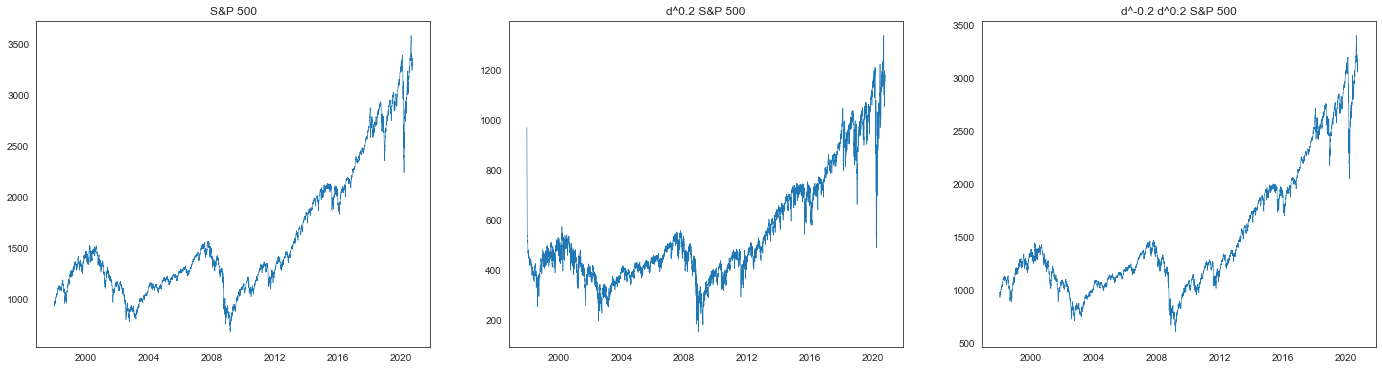

In [26]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.title("S&P 500")
plt.plot(spx, linewidth=0.6)

plt.subplot(1, 3, 2)
plt.title("d^{} S&P 500".format(d))
plt.plot(spxd, linewidth=0.6)

plt.subplot(1, 3, 3)
plt.title("d^{} d^{} S&P 500".format(-d, d))
plt.plot(spxi, linewidth=0.6)

plt.show()

## 5.5

### 5.5 (a)

In [27]:
spxlog = spx.apply(np.log)

spxlogcumsum = spxlog.cumsum()
spxlogcumsum

Date
1997-12-31        6.877739
1998-01-02       13.760218
1998-01-05       20.644776
1998-01-06       27.518540
1998-01-07       34.389631
                  ...     
2020-09-24    41792.094032
2020-09-25    41800.195243
2020-09-28    41808.312436
2020-09-29    41816.424805
2020-09-30    41824.545394
Name: Adj Close, Length: 5725, dtype: float64

### 5.5 (b)

In [28]:
from fracdiff.tol import window_from_tol_coef

window = window_from_tol_coef(0.5, 1e-5)
window

928

In [29]:
X = np.array(spxlogcumsum).reshape(-1, 1)

f = FracdiffStat(window=window, mode="valid", upper=2)
diff = f.fit_transform(X)

print("* Order: {:.2f}".format(f.d_[0]))

* Order: 1.73


In [30]:
# Check stationarity
adf_test(diff)

* ADF statistics: -2.868
* ADF p-value: 0.049


### 5.5 (c)

In [31]:
X = spxlog.values.reshape(-1, 1)

f = FracdiffStat(window=window, mode="valid")
spxlogd = pd.Series(f.fit_transform(X).reshape(-1), index=spx.index[-diff.size :])

In [32]:
corr = np.corrcoef(spxlog[-spxd.size :], spxd)[0, 1]

print("* Correlation: {:.2f}".format(corr))

* Correlation: 0.98


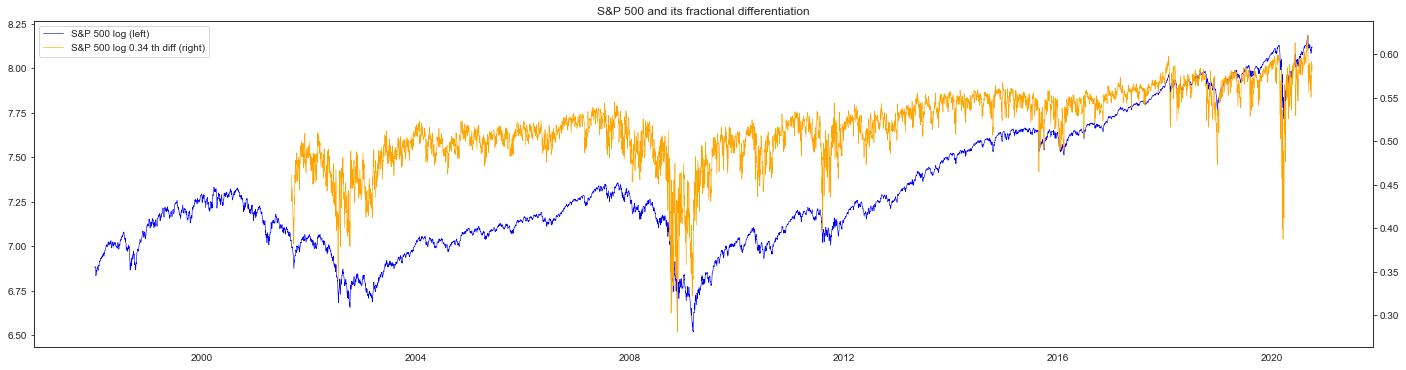

In [33]:
fig, ax_s = plt.subplots(figsize=(24, 6))
ax_d = ax_s.twinx()

plot_s = ax_s.plot(
    spxlog[-spxd.size :], color="blue", linewidth=0.6, label="S&P 500 log (left)"
)
plot_d = ax_d.plot(
    spxlogd,
    color="orange",
    linewidth=0.6,
    label=f"S&P 500 log {f.d_[0]:.2f} th diff (right)",
)
plots = plot_s + plot_d

plt.title("S&P 500 and its fractional differentiation")
ax_s.legend(plots, [p.get_label() for p in plots], loc=0)

plt.show()

### 5.5 (d)

In [34]:
from cointanalysis import CointAnalysis

- It is nonsense to discuss cointegration of `Xd` because cointegration is defined among non-stationary processes and `Xd` is stationary.
- So we will instead discuss cointegration between 1.3 th differentiated time-series, which is non-stationary, with the original time-series.

In [35]:
d = 0.30

# Check non-stationarity
diff = fdiff(spxlog, d, window=window, mode="valid")
spxlogd = pd.Series(diff, index=spxlog.index[-diff.size :])
adf_test(diff)

* ADF statistics: -2.445
* ADF p-value: 0.129


In [36]:
pair = np.stack((spxlog[-diff.size :], diff), 1)

ca = CointAnalysis().test(pair)

print("* AEG statistics: {:.2f}".format(ca.stat_))
print("* AEG p-value: {:.2e}".format(ca.pvalue_))

* AEG statistics: -4.26
* AEG p-value: 2.96e-03


- They are cointegrated.
- Rough reason: For `d=0`, two series are exactly the same and so trivially cointegrated. For `d` that is close to the minimum value to make fracdiff stationary, one can make an almost stationary series by adding the original series multiplied by an infinitesimally small coefficient to fracdiff. One can expect cointegration for any `d` in between assuming an interpolation.

In [37]:
ca.fit(pair)

ys = (-spxlog * ca.coef_[0])[-spxlogd.size :]
yd = spxlogd * ca.coef_[1] - ca.mean_

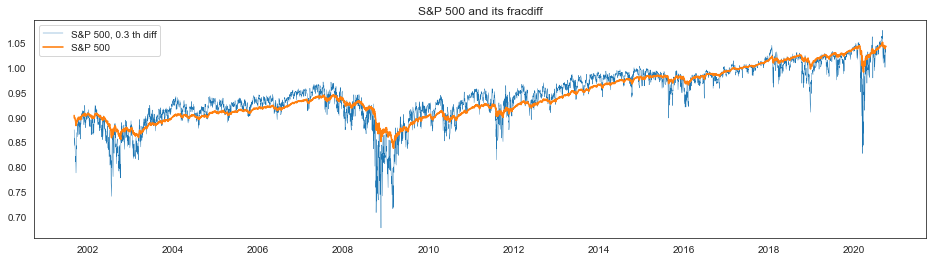

In [38]:
plt.figure(figsize=(16, 4))

plt.plot(yd, linewidth=0.4, label=f"S&P 500, {d} th diff")
plt.plot(ys, linewidth=1.6, label="S&P 500")

plt.legend()
plt.title("S&P 500 and its fracdiff")
plt.show()

In [39]:
spread = ca.transform(pair)

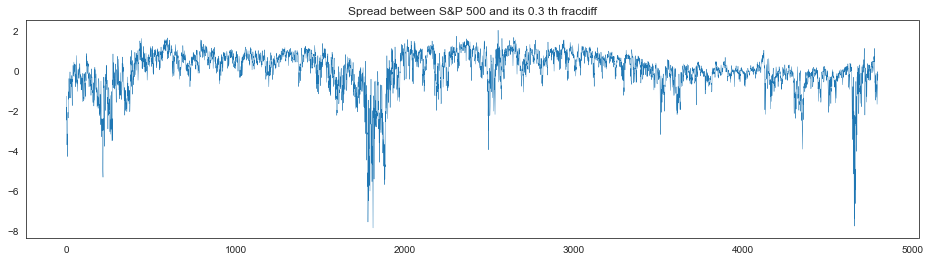

In [40]:
plt.figure(figsize=(16, 4))
plt.plot(spread, linewidth=0.4)
plt.title("Spread between S&P 500 and its {} th fracdiff".format(d))
plt.show()

### 5.5 (e)

In [41]:
from scipy.stats import kurtosis, skew
from statsmodels.stats.stattools import jarque_bera

In [42]:
spxlogd.values.reshape(-1, 1).shape

(4798, 1)

In [43]:
X = spxlog.values.reshape(-1, 1)

f = FracdiffStat(window=window, mode="valid")
spxlogd = pd.Series(f.fit_transform(X).reshape(-1), index=spx.index[-diff.size :])

spxlr = spxlog.diff()[-spxlogd.size :]  # logreturn

pd.DataFrame(
    {
        "S&P 500": jarque_bera(spx[-spxlogd.size :]),
        "S&P 500 fracdiff": jarque_bera(spxlogd),
        "S&P 500 logreturn": jarque_bera(spxlr),
    },
    index=["JB statistics", "p-value", "skew", "kurtosis"],
).round(3)

,S&P 500,S&P 500 fracdiff,S&P 500 logreturn
JB statistics,637.418,1110.285,29941.995
p-value,0.000,0.000,0.000
skew,0.873,-0.834,-0.445
kurtosis,2.629,4.664,15.206


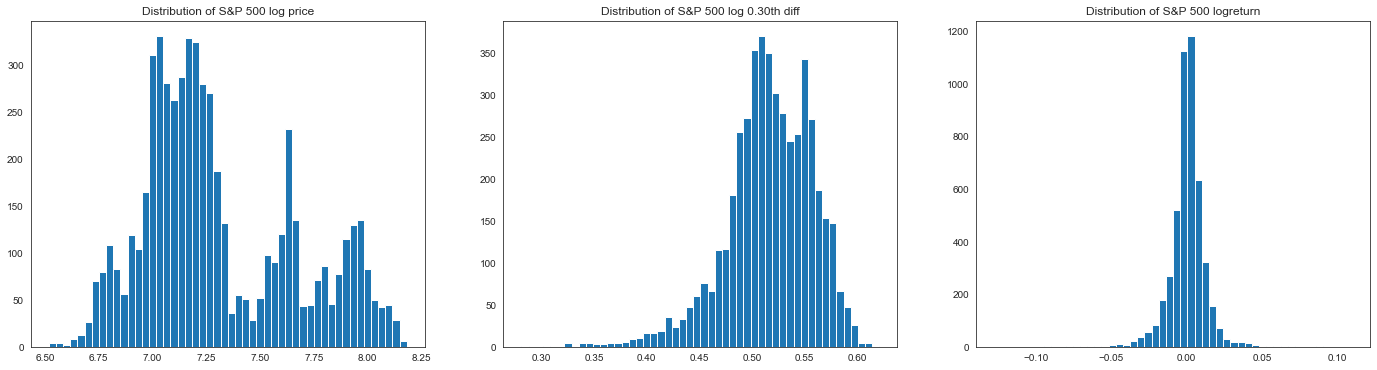

In [44]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.title(f"Distribution of S&P 500 log price")
plt.hist(spxlog, bins=50)

plt.subplot(1, 3, 2)
plt.title(f"Distribution of S&P 500 log {d:.2f}th diff")
plt.hist(spxlogd, bins=50)

plt.subplot(1, 3, 3)
plt.title("Distribution of S&P 500 logreturn")
plt.hist(spxlr, bins=50)

plt.show()